# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc,f1_score,recall_score,roc_auc_score
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [0]:
#100000 points from the dataframe

final = final[0:100000]

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [6]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [7]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [8]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [11]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [12]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [14]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 100000/100000 [00:49<00:00, 2019.66it/s]


In [15]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [16]:
#Preprocessing the summary column.

preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 100000/100000 [00:49<00:00, 2038.40it/s]


In [17]:
#merge the text-review and summary

preprocessed_text = []
for i in tqdm(range(len(preprocessed_reviews))):
  preprocessed_text.append(' '.join([preprocessed_reviews[i],preprocessed_summary[i]]))

100%|██████████| 100000/100000 [00:00<00:00, 723895.98it/s]


In [0]:
#Store the preprocessed text in a pickle file
f = open('preprocessed_text.pkl','rb')
preprocessed_text = pickle.load(f)

In [20]:
len(preprocessed_text)

100000

In [0]:
#Split the datset into train and test set in ratio 70:30

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(preprocessed_text,final['Score'],test_size=0.3,random_state=0)  

# [4] Featurization

## [4.1] BAG OF WORDS

In [32]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
bow_train = count_vect.fit_transform(x_train)
bow_test = count_vect.transform(x_test)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

print("the type of count vectorizer ",type(bow_train))
print("the shape of out text BOW vectorizer ",bow_train.get_shape())
print("the number of unique words ", bow_train.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaaaaaaaaa', 'aaaaaaaaagghh', 'aaaaaagggghhhh', 'aaaaaah', 'aaaaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 52094)
the number of unique words  52094


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [35]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf_train = tf_idf_vect.fit_transform(x_train)
tfidf_test = tf_idf_vect.transform(x_test)

print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

print("the number of unique words including both unigrams and bigrams ", tfidf_train.get_shape()[1])

some sample features(unique words in the corpus) ['abandon', 'abandoned', 'abc', 'abdominal', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat']
the number of unique words including both unigrams and bigrams  42077


## [4.4] Word2Vec

In [22]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in tqdm(x_train):
    list_of_sentance_train.append(sentance.split())
list_of_sentance_test=[]
for sentance in tqdm(x_test):
    list_of_sentance_test.append(sentance.split())

100%|██████████| 30000/30000 [00:00<00:00, 158185.69it/s]


In [23]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=200, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('terrific', 0.7705979943275452), ('excellent', 0.7595007419586182), ('fantastic', 0.7473729252815247), ('awesome', 0.7419826984405518), ('wonderful', 0.7156973481178284), ('good', 0.6679390668869019), ('fabulous', 0.6057403087615967), ('perfect', 0.5885062217712402), ('nice', 0.5843549966812134), ('incredible', 0.5782597064971924)]
[('greatest', 0.7571519017219543), ('disgusting', 0.6817914247512817), ('awful', 0.6644400954246521), ('nastiest', 0.6401912569999695), ('terrible', 0.6308414936065674), ('horrible', 0.6260770559310913), ('best', 0.6004571318626404), ('foul', 0.5753289461135864), ('experienced', 0.5739648342132568), ('coolest', 0.5548787117004395)]


In [24]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16521
sample words  ['go', 'hate', 'junk', 'food', 'need', 'snack', 'story', 'life', 'wonderful', 'taste', 'good', 'enough', 'children', 'like', 'healthy', 'keep', 'box', 'car', 'case', 'run', 'house', 'without', 'breakfast', 'daughter', 'needs', 'quick', 'right', 'school', 'great', 'living', 'california', 'drawbacks', 'one', 'lack', 'flake', 'bars', 'know', 'sounds', 'silly', 'assure', 'serious', 'issue', 'amazon', 'rescue', 'not', 'ready', 'die', 'yet', 'always', 'looking']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [25]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
    
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)

100%|██████████| 30000/30000 [01:00<00:00, 499.11it/s]


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_train = []; # the tfidf-w2v for each sentence/review is stored in this list

for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train.append(sent_vec)

tfidf_test = []; # the tfidf-w2v for each sentence/review is stored in this list

for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test.append(sent_vec)


# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

In [0]:
#import libraries
from sklearn.ensemble import  RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sn

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

The best parameters found are {'max_depth': 100, 'n_estimators': 200}


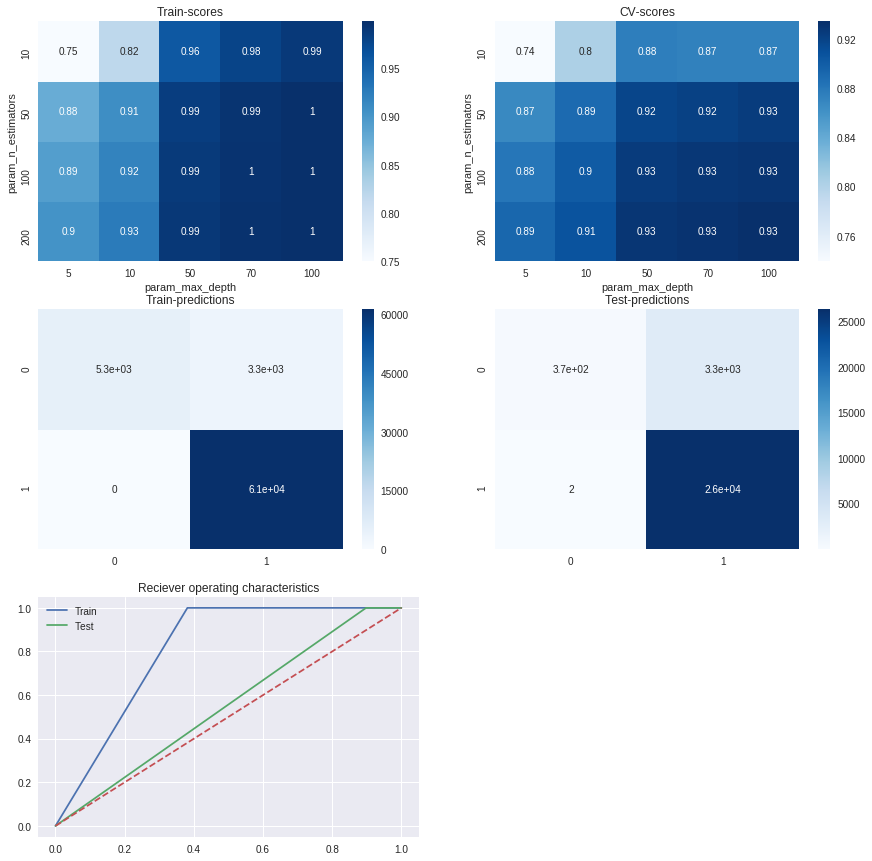

Auc score on test data 0.5510218040548585
The True Positive Rate 0.9999241476087534
The True Negative Rate 0.9946380697050938
The f1_score on test data 0.9417080401471587


In [0]:
#Apply randomforestclassifier on bow vectors

#Use gridsearchCV to find the optimal parameters based on auc scores
params = {'n_estimators':[10,50,100,200],'max_depth':[5,10,50,70,100]}

grid_model = GridSearchCV(RandomForestClassifier(n_jobs=-1),params,scoring='roc_auc',cv=5,n_jobs=-1,verbose=10)#find parameters based on auc scores
grid_model.fit(bow_train,y_train)

print('The best parameters found are',grid_model.best_params_)

#Create a dataframeof gridsearch results
df_gridsearch = pd.DataFrame(grid_model.cv_results_)
pvt_train = df_gridsearch.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_train_score')
pvt_test = df_gridsearch.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_test_score')

optimal_depth = grid_model.best_estimator_.max_depth
optimal_estimators = grid_model.best_estimator_.n_estimators

#Train a RF model using the best hyperparamters
RF = RandomForestClassifier(n_estimators=optimal_estimators,max_depth=optimal_depth)
RF.fit(bow_train,y_train)

#predict on train and test data
y_pred = RF.predict(bow_test)
train_pred = RF.predict(bow_train)

#confusion matrices of train,test predictions
conf_train = confusion_matrix(y_train,train_pred)
conf_test = confusion_matrix(y_test,y_pred)

#To obtain fpr,tpr of roc curve
fpr,tpr,_ = roc_curve(y_train,train_pred)
fpr2,tpr2,_ = roc_curve(y_test,y_pred)

#plot train,CV scores and confusion matrices
plt.figure(1,figsize=(15,15))
plt.subplot(3,2,1)
plt.title('Train-scores')
sn.heatmap(pvt_train,annot=True,cmap='Blues')
plt.subplot(3,2,2)
plt.title('CV-scores')
sn.heatmap(pvt_test,annot=True,cmap='Blues')
plt.subplot(3,2,3)
plt.title('Train-predictions')
sn.heatmap(conf_train,annot=True,cmap='Blues')
plt.subplot(3,2,4)
plt.title('Test-predictions')
sn.heatmap(conf_test,annot=True,cmap='Blues')
plt.subplot(3,2,5)
plt.title('Reciever operating characteristics')
plt.plot(fpr,tpr,label='Train')
plt.plot(fpr2,tpr2,label='Test')
plt.plot([0,1],[0,1],linestyle='--')
plt.legend()
plt.show()

#print the scores of various metrics
print('Auc score on test data',roc_auc_score(y_test,y_pred))
print('The True Positive Rate',recall_score(y_test,y_pred))
print('The True Negative Rate',conf_test[0][0]/(conf_test[0][0] + conf_test[1][0]))
print('The f1_score on test data',f1_score(y_test,y_pred))


### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

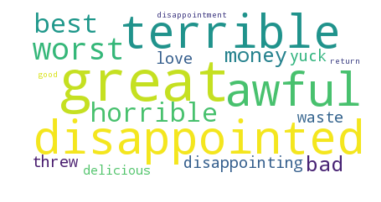

In [0]:
#Code snippet from github.com/amueller/word_cloud/blob/master/examples/simple.py
#Print a word cloud of important features
from wordcloud import WordCloud

importance = np.argsort(RF.feature_importances_)[::-1]
important_features = np.take(count_vect.get_feature_names(),importance[0:20])
txt = ' '.join([rev for rev in list(important_features)])
cloud = WordCloud(background_color='white').generate(txt)
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

The best parmeters are  {'max_depth': 100, 'n_estimators': 200}


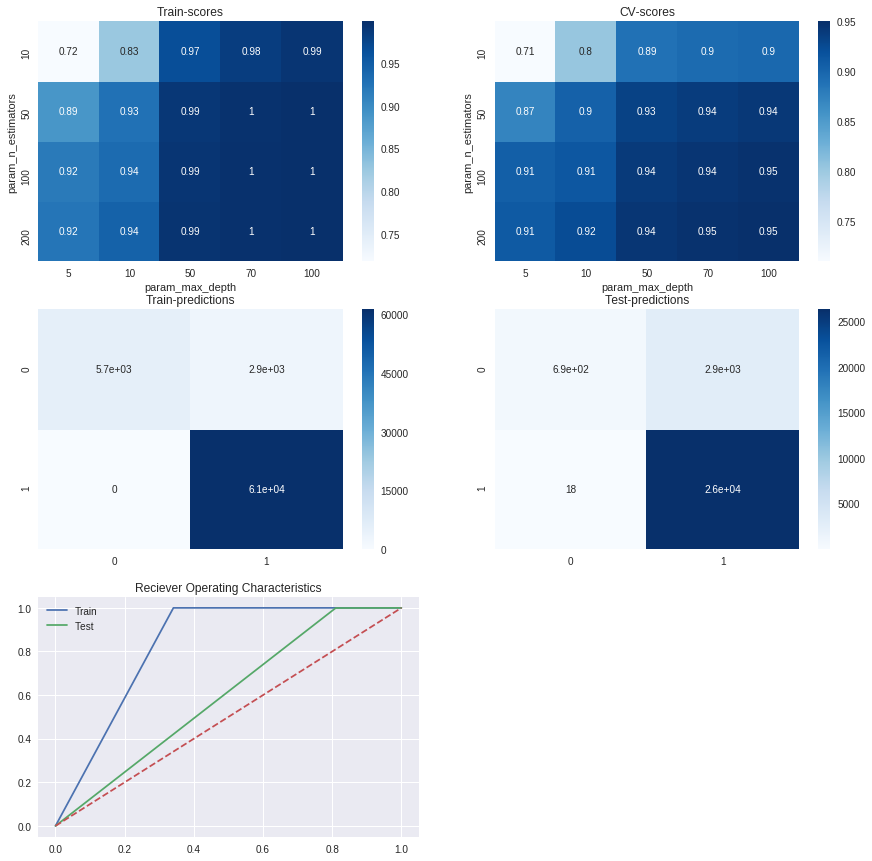

The AUC score is 0.5946215048669706
The True Positive Rate is 0.9993173284787803
The True Negative Rate is 0.9745762711864406
The f1_score is 0.9468010564329219


In [0]:
#Hyperparameter search using gridsearchCV 

params = {'n_estimators':[10,50,100,200],'max_depth':[5,10,50,70,100]}
grid_model = GridSearchCV(RandomForestClassifier(n_jobs=-1),params,scoring='roc_auc',cv=5,n_jobs=-1,verbose=10)#find best parameters based on auc scores
grid_model.fit(tfidf_train,y_train)

print('The best parmeters are ',grid_model.best_params_)

optimal_depth = grid_model.best_estimator_.max_depth
optimal_estimators = grid_model.best_estimator_.n_estimators

#create a datframe of train results
df_gridsearch = pd.DataFrame(grid_model.cv_results_)
pvt_train = df_gridsearch.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_train_score')
pvt_test = df_gridsearch.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_test_score')

#Train a Rfclassifier on best parameters
RF = RandomForestClassifier(n_estimators=optimal_estimators,max_depth=optimal_depth)
RF.fit(tfidf_train,y_train)

#predict on test and train data
y_pred = RF.predict(tfidf_test)
train_pred = RF.predict(tfidf_train)

#Create confusion matrices of predictions
conf_train = confusion_matrix(y_train,train_pred)
conf_test = confusion_matrix(y_test,y_pred)

fpr,tpr,_ = roc_curve(y_train,train_pred)
fpr2,tpr2,_ = roc_curve(y_test,y_pred)

#plot the train,test scores and predictions
plt.figure(1,figsize=(15,15))
plt.subplot(3,2,1)
plt.title('Train-scores')
sn.heatmap(pvt_train,annot=True,cmap='Blues')
plt.subplot(3,2,2)
plt.title('CV-scores')
sn.heatmap(pvt_test,cmap='Blues',annot=True)
plt.subplot(3,2,3)
plt.title('Train-predictions')
sn.heatmap(conf_train,cmap='Blues',annot=True)
plt.subplot(3,2,4)
plt.title('Test-predictions')
sn.heatmap(conf_test,annot=True,cmap='Blues')
plt.subplot(3,2,5)
plt.title('Reciever Operating Characteristics')
plt.plot(fpr,tpr,label='Train')
plt.plot(fpr2,tpr2,label='Test')
plt.plot([0,1],[0,1],linestyle='--')
plt.legend()
plt.show()

#print the scores of various metrics
print('The AUC score is',roc_auc_score(y_test,y_pred))
print('The True Positive Rate is',recall_score(y_test,y_pred))
print('The True Negative Rate is',conf_test[0][0]/(conf_test[0][0] + conf_test[1][0]))
print('The f1_score is',f1_score(y_test,y_pred))

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

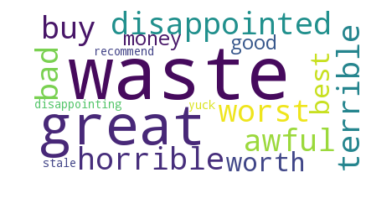

In [0]:
#Print a word cloud of important features using wordcloud
from wordcloud import WordCloud
#get important features from the model
importances = np.argsort(RF.feature_importances_)[::-1]
important_features = np.take(tf_idf_vect.get_feature_names(),importances[0:20])
text = ' '.join([rev for rev in list(important_features)])
cloud = WordCloud(background_color='white').generate(text)

plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

The best parameters found using gridsearch are {'max_depth': 13, 'n_estimators': 200}
The Auc score on test data 0.9297954278963777


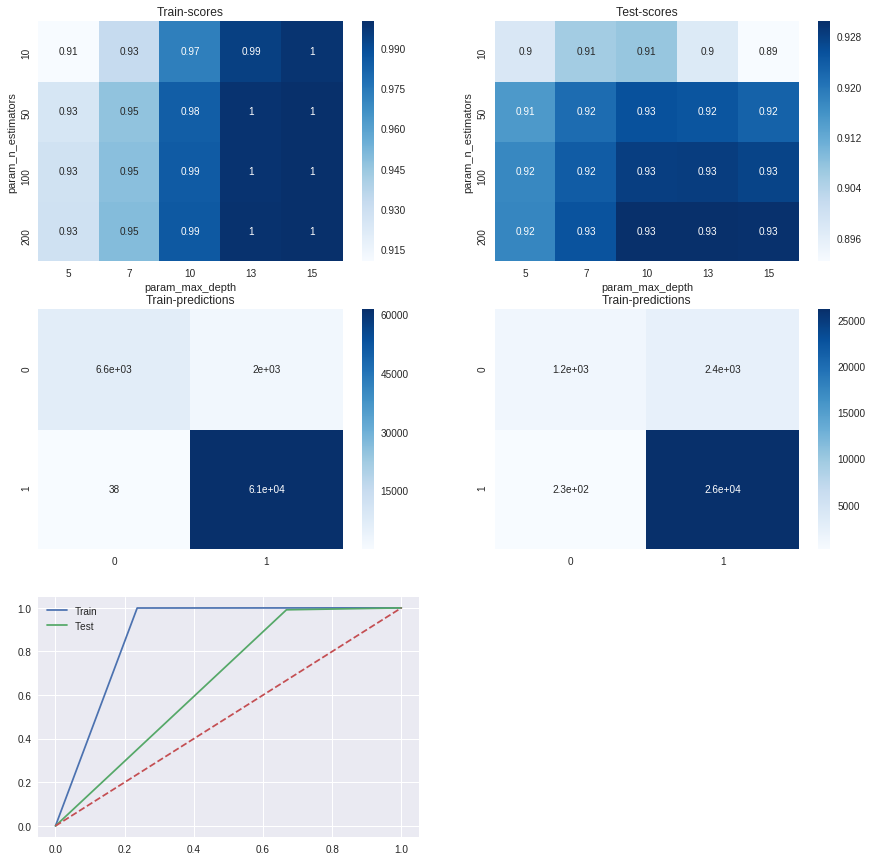

The auc score on test data is 0.6617356818511441
The True Positive rate is  0.9912390488110138
The True Negative Rate is 0.8393602225312935
The f1_score is 0.9516284658377178


In [0]:
#hyperparameter search using gridsearchCV

params = {'n_estimators':[10,50,100,200],'max_depth':[5,7,10,13,15]}
grid_model = GridSearchCV(RandomForestClassifier(),params,scoring='roc_auc',cv=5,n_jobs=-1,verbose=10)
grid_model.fit(sent_vectors_train,y_train)

print('The best parameters found using gridsearch are',grid_model.best_params_)
print('The Auc score on test data',grid_model.score(sent_vectors_test,y_test))

optimal_estimators = grid_model.best_estimator_.n_estimators
optimal_depth = grid_model.best_estimator_.max_depth

#create a dataframe of train results
df_gridsearch = pd.DataFrame(grid_model.cv_results_)
pvt_train = df_gridsearch.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_train_score')
pvt_test = df_gridsearch.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_test_score')

#Train a RFclassifier on best parameters
RF = RandomForestClassifier(n_estimators=optimal_estimators,max_depth=optimal_depth)
RF.fit(sent_vectors_train,y_train)

#predict on tain and test data
y_pred = RF.predict(sent_vectors_test)
train_pred = RF.predict(sent_vectors_train)

#obtain confuiosn matrices
conf_train = confusion_matrix(y_train,train_pred)
conf_test = confusion_matrix(y_test,y_pred)

#obtain fpr and tpr values from roc_curve
fpr,tpr,_ = roc_curve(y_train,train_pred)
fpr2,tpr2,_ = roc_curve(y_test,y_pred)

#plot confusion_matrices and train,test scores 
plt.figure(1,figsize=(15,15))
plt.subplot(3,2,1)
plt.title('Train-scores')
sn.heatmap(pvt_train,cmap='Blues',annot=True)
plt.subplot(3,2,2)
plt.title('Test-scores')
sn.heatmap(pvt_test,cmap='Blues',annot=True)
plt.subplot(3,2,3)
plt.title('Train-predictions')
sn.heatmap(conf_train,cmap='Blues',annot=True)
plt.subplot(3,2,4)
plt.title('Train-predictions')
sn.heatmap(conf_test,cmap='Blues',annot=True)
plt.subplot(3,2,5)
plt.plot(fpr,tpr,label='Train')
plt.plot(fpr2,tpr2,label='Test')
plt.plot([0,1],[0,1],linestyle='--')
plt.legend()
plt.show()

#scores of various metrics
print('The auc score on test data is',roc_auc_score(y_test,y_pred))
print('The True Positive rate is ',recall_score(y_test,y_pred))
print('The True Negative Rate is',conf_test[0][0]/(conf_test[0][0] + conf_test[1][0]))
print('The f1_score is',f1_score(y_test,y_pred))

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

The best parameters found using gridsearch are {'max_depth': 13, 'n_estimators': 200}


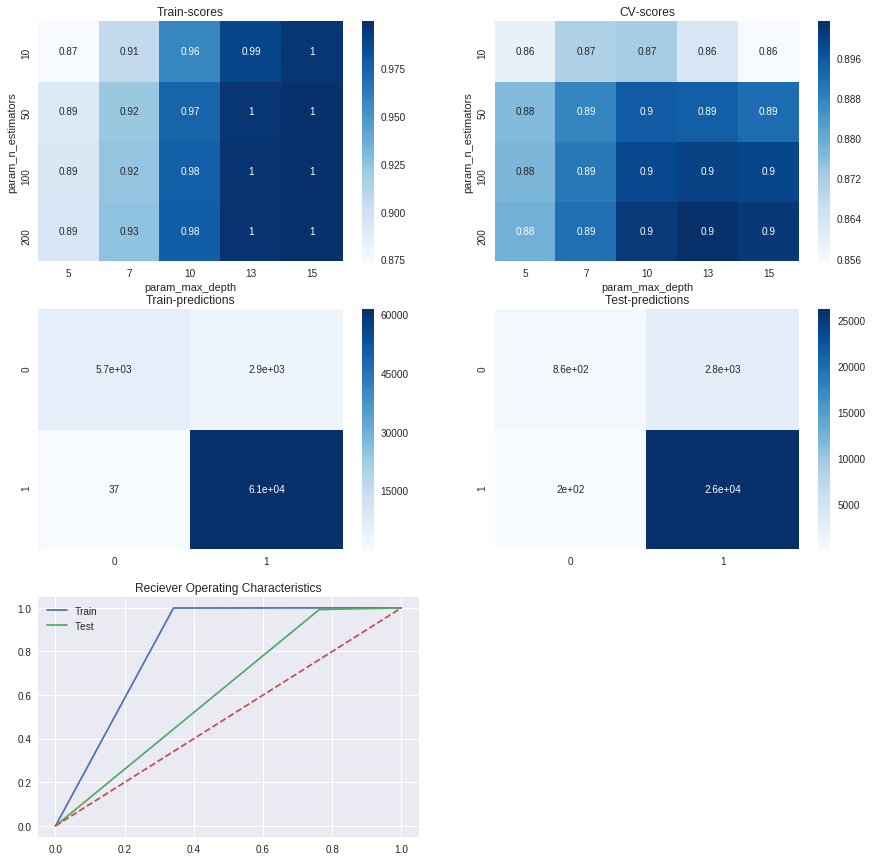

The AUC score is 0.614804191373892
The True Positive Rate is 0.99233890848409
The True Negative Rate is 0.8101503759398496
The f1_score is 0.9462416143789668


In [0]:
#Hyperparameter search using gridsearchCV

params = {'n_estimators': [10,50,100,200],'max_depth': [5,7,10,13,15]}
grid_model = GridSearchCV(RandomForestClassifier(),params,scoring='roc_auc',cv=5,n_jobs=-1,verbose=10)
grid_model.fit(tfidfw2v_train,y_train)

#print the optimal parameters
print('The best parameters found using gridsearch are',grid_model.best_params_)

#Create a dataframe of the train results
df_grid = pd.DataFrame(grid_model.cv_results_)
pvt_train = df_grid.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_train_score')
pvt_test = df_grid.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_test_score')

optimal_depth = grid_model.best_estimator_.max_depth
optimal_estimators = grid_model.best_estimator_.n_estimators

#Train a RF model on the best parameters
RF = RandomForestClassifier(n_estimators=optimal_estimators,max_depth=optimal_depth)
RF.fit(tfidfw2v_train,y_train)

#predict on test and train data
y_pred = RF.predict(tfidfw2v_test)
train_pred = RF.predict(tfidfw2v_train)

#Create confusion matrices of predictions
conf_train = confusion_matrix(y_train,train_pred)
conf_test = confusion_matrix(y_test,y_pred)

fpr,tpr,_ = roc_curve(y_train,train_pred)
fpr2,tpr2,_ = roc_curve(y_test,y_pred)

#plot the train,test scores and predictions
plt.figure(1,figsize=(15,15))
plt.subplot(3,2,1)
plt.title('Train-scores')
sn.heatmap(pvt_train,annot=True,cmap='Blues')
plt.subplot(3,2,2)
plt.title('CV-scores')
sn.heatmap(pvt_test,cmap='Blues',annot=True)
plt.subplot(3,2,3)
plt.title('Train-predictions')
sn.heatmap(conf_train,cmap='Blues',annot=True)
plt.subplot(3,2,4)
plt.title('Test-predictions')
sn.heatmap(conf_test,annot=True,cmap='Blues')
plt.subplot(3,2,5)
plt.title('Reciever Operating Characteristics')
plt.plot(fpr,tpr,label='Train')
plt.plot(fpr2,tpr2,label='Test')
plt.plot([0,1],[0,1],linestyle='--')
plt.legend()
plt.show()

#print the scores of various metrics
print('The AUC score is',roc_auc_score(y_test,y_pred))
print('The True Positive Rate is',recall_score(y_test,y_pred))
print('The True Negative Rate is',conf_test[0][0]/(conf_test[0][0] + conf_test[1][0]))
print('The f1_score is',f1_score(y_test,y_pred))

## [5.2] Applying GBDT using XGBOOST

In [0]:
#import the libraries
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sn

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

The best parameters found are {'max_depth': 9, 'n_estimators': 200}


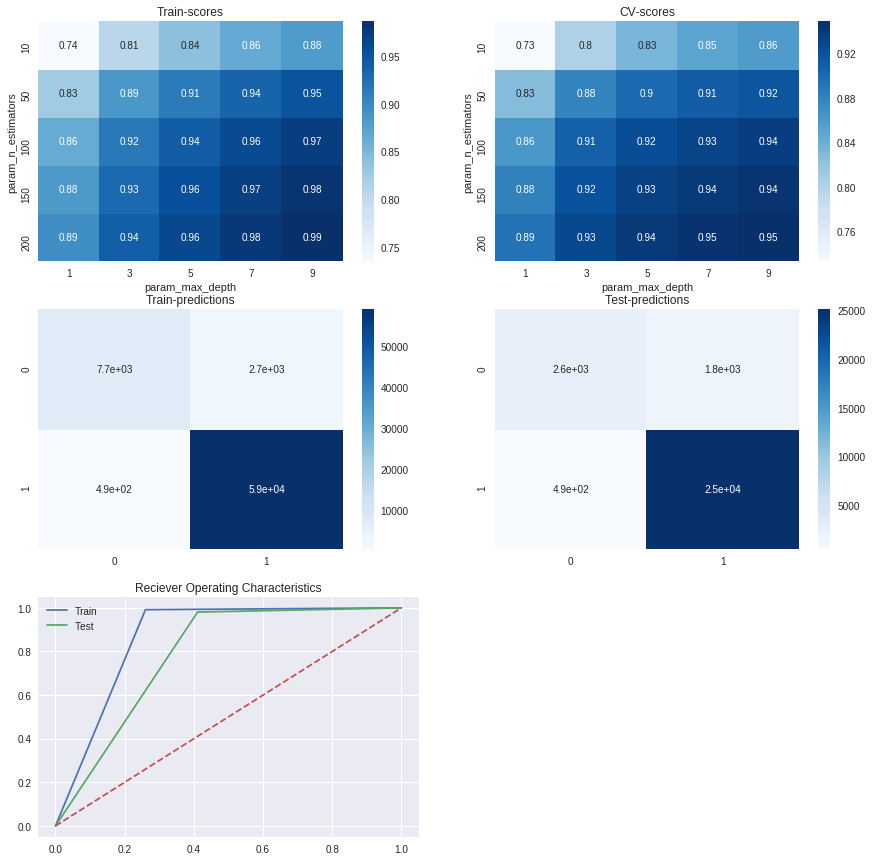

The AUC score is 0.7848883595619949
The True Positive Rate is [0.         0.98071066 1.        ]
The True Negative Rate is 0.8396103896103896
The f1_score is 0.9562535693889206


In [33]:
#Hyperparameter search using gridsearchCV , to find optimal max_depth and n_estimators

#xgboostclassifier class parameters
# max_depth=3,  learning_rate=0.1,  n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, 
#  nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, 
#    reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs

# parameters of fit method
#  X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds,
#     verbose=True, xgb_model=None, sample_weight_eval_set=None, callbacks=None


#xgboost classifier with default column and row sampling ,learning_rate-0.1,gamma-0
params = {'n_estimators':[10,50,100,150,200],'max_depth':[1,3,5,7,9]}
grid_model = GridSearchCV(XGBClassifier(),params,scoring='roc_auc',n_jobs=-1,cv=5,verbose=10)#gridsearch to find optimal parameters based on auc scores
grid_model.fit(bow_train,y_train)  #fit train-data with no early stopping


#optimal parameters
optimal_depth = grid_model.best_estimator_.max_depth
optimal_estimators = grid_model.best_estimator_.n_estimators

print('The best parameters found are',grid_model.best_params_)

#create a dataframe of the cv results
df = pd.DataFrame(grid_model.cv_results_)
train_pvt = df.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_train_score')
test_pvt = df.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_test_score')

#USe the best params to train a xgboost classifier
xgb = XGBClassifier(n_estimators=optimal_estimators,max_depth=optimal_depth)
xgb.fit(bow_train,y_train)

#predictions on train and test data
y_pred = xgb.predict(bow_test)
train_pred = xgb.predict(bow_train)

#confusion matrices
conf_train = confusion_matrix(y_train,train_pred)
conf_test = confusion_matrix(y_test,y_pred)

#use roc_curve to obtrain fpr and tpr
fpr,tpr,_ = roc_curve(y_train,train_pred)
fpr2,tpr2,_ = roc_curve(y_test,y_pred)

#plot the train,test scores and predictions
plt.figure(1,figsize=(15,15))
plt.subplot(3,2,1)
plt.title('Train-scores')
sn.heatmap(train_pvt,annot=True,cmap='Blues')
plt.subplot(3,2,2)
plt.title('CV-scores')
sn.heatmap(test_pvt,cmap='Blues',annot=True)
plt.subplot(3,2,3)
plt.title('Train-predictions')
sn.heatmap(conf_train,cmap='Blues',annot=True)
plt.subplot(3,2,4)
plt.title('Test-predictions')
sn.heatmap(conf_test,annot=True,cmap='Blues')
plt.subplot(3,2,5)
plt.title('Reciever Operating Characteristics')
plt.plot(fpr,tpr,label='Train')
plt.plot(fpr2,tpr2,label='Test')
plt.plot([0,1],[0,1],linestyle='--')
plt.legend()
plt.show()

#print the scores of various metrics
print('The AUC score is',roc_auc_score(y_test,y_pred))
print('The True Positive Rate is',tpr2)
print('The True Negative Rate is',conf_test[0][0]/(conf_test[0][0] + conf_test[1][0]))
print('The f1_score is',f1_score(y_test,y_pred))


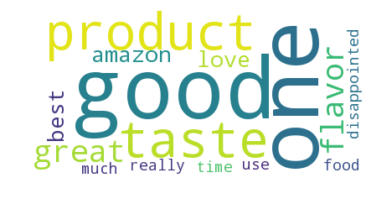

In [34]:
#Code snippet from github.com/amueller/word_cloud/blob/master/examples/simple.py
#Print a word cloud of important features
from wordcloud import WordCloud

importance = np.argsort(xgb.feature_importances_)[::-1]
important_features = np.take(count_vect.get_feature_names(),importance[0:20])
txt = ' '.join([rev for rev in list(important_features)])
cloud = WordCloud(background_color='white').generate(txt)
plt.imshow(cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

The Best parameters found using gridsearch are {'max_depth': 9, 'n_estimators': 200}


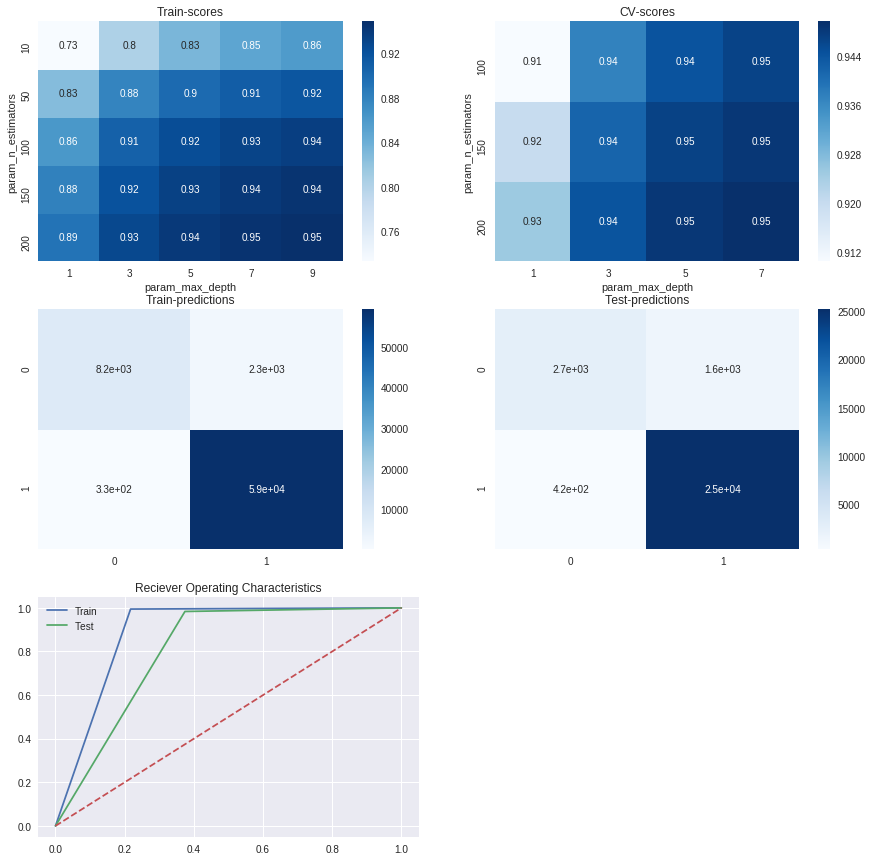

In [37]:
#Apply xgboostclassifier on tfidf vectors
#Hyperparameter search using gridsearchCV with default col and row sampling

params = {'n_estimators':[50,100,150,200],'max_depth':[1,3,5,7,9]}
tfidf_grid = GridSearchCV(XGBClassifier(),params,scoring='roc_auc',cv=5,n_jobs=-1,verbose=10)
tfidf_grid.fit(tfidf_train,y_train)

print('The Best parameters found using gridsearch are',grid_model.best_params_)

optimal_estimators = grid_model.best_estimator_.n_estimators
optimal_depth = grid_model.best_estimator_.max_depth
#create pivot tables to visulize train and test scores
df = pd.DataFrame(tfidf_grid.cv_results_)
pvt_train = df.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_train_score')
pvt_train = df.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_test_score')

#train a clssifier using the best parameters
xgb = XGBClassifier(n_estimators=optimal_estimators,max_depth=optimal_depth)
xgb.fit(tfidf_train,y_train)

#Use the best model to predict on test and train data
y_pred = xgb.predict(tfidf_test)
train_pred = xgb.predict(tfidf_train)

conf_train = confusion_matrix(y_train,train_pred)
conf_test = confusion_matrix(y_test,y_pred)

#obtain fpr,tpr from roc_curve
fpr,tpr,_ = roc_curve(y_train,train_pred)
fpr2,tpr2,_ = roc_curve(y_test,y_pred)

#plot heatmap and roc curves
plt.figure(1,figsize=(15,15))
plt.subplot(3,2,1)
plt.title('Train-scores')
sn.heatmap(pvt_train,cmap='Blues',annot=True)
plt.subplot(3,2,2)
plt.title('CV-scores')
sn.heatmap(pvt_test,cmap='Blues',annot=True)
plt.subplot(3,2,3)
plt.title('Train-predictions')
sn.heatmap(conf_train,cmap='Blues',annot=True)
plt.subplot(3,2,4)
plt.title('Test-predictions')
sn.heatmap(conf_test,cmap='Blues',annot=True)
plt.subplot(3,2,5)
plt.title('Reciever Operating Characteristics')
plt.plot(fpr,tpr,label='Train')
plt.plot(fpr2,tpr2,label='Test')
plt.plot([0,1],[0,1],linestyle='--')
plt.legend()
plt.show()

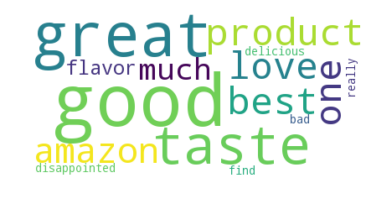

In [38]:
#Print a word cloud of important features

importance = np.argsort(xgb.feature_importances_)[::-1]
important_features = np.take(tf_idf_vect.get_feature_names(),importance[0:20])
txt = ' '.join([rev for rev in list(important_features)])
cloud = WordCloud(background_color='white').generate(txt)
plt.imshow(cloud,interpolation='bilinear') #print the image , interpolation to smoothen the image
plt.axis('off')
plt.show()

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

The best parameters found are  {'max_depth': 7, 'n_estimators': 200}


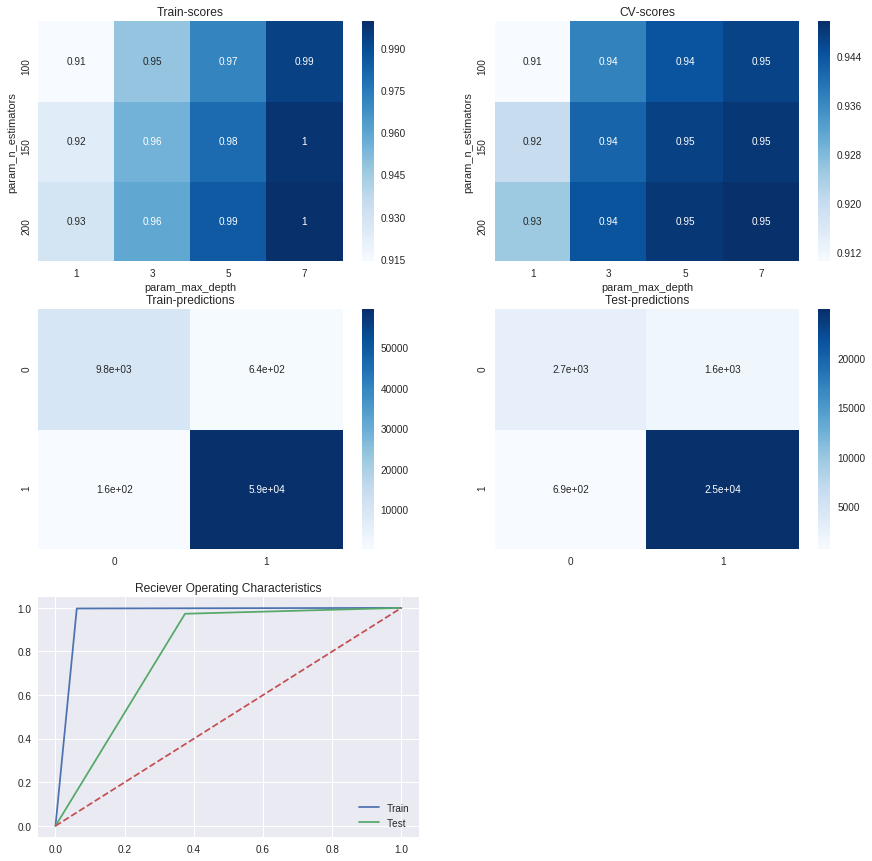

In [31]:
#hyperparmaeter search using gridsearchCV
#create arrays of test and train data

w2v_train = np.array(sent_vectors_train)
w2v_test = np.array(sent_vectors_test)

params = {'n_estimators':[100,150,200],'max_depth':[1,3,5,7]}
w2v_grid = GridSearchCV(XGBClassifier(),params,scoring='roc_auc',cv=5,n_jobs=-1,verbose=10)
w2v_grid.fit(w2v_train,y_train)

#print the best parameters
print('The best parameters found are ',w2v_grid.best_params_)

#create pivot tables to visulize train and test scores
df = pd.DataFrame(w2v_grid.cv_results_)
pvt_train = df.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_train_score')
pvt_test = df.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_test_score')

optimal_depth = w2v_grid.best_estimator_.max_depth
optimal_estimators = w2v_grid.best_estimator_.n_estimators

#train a classifier using the best parameters
#xgb = XGBClassifier(n_estimators=optimal_estimators,max_depth=optimal_depth)
#xgb.fit(w2v_train,y_train)

#Use the best model to predict on test and train data
y_pred = xgb.predict(w2v_test)
train_pred = xgb.predict(w2v_train)

conf_train = confusion_matrix(y_train,train_pred)
conf_test = confusion_matrix(y_test,y_pred)

#obtain fpr,tpr from roc_curve
fpr,tpr,_ = roc_curve(y_train,train_pred)
fpr2,tpr2,_ = roc_curve(y_test,y_pred)

#plot heatmap and roc curves
plt.figure(1,figsize=(15,15))
plt.subplot(3,2,1)
plt.title('Train-scores')
sn.heatmap(pvt_train,cmap='Blues',annot=True)
plt.subplot(3,2,2)
plt.title('CV-scores')
sn.heatmap(pvt_test,cmap='Blues',annot=True)
plt.subplot(3,2,3)
plt.title('Train-predictions')
sn.heatmap(conf_train,cmap='Blues',annot=True)
plt.subplot(3,2,4)
plt.title('Test-predictions')
sn.heatmap(conf_test,cmap='Blues',annot=True)
plt.subplot(3,2,5)
plt.title('Reciever Operating Characteristics')
plt.plot(fpr,tpr,label='Train')
plt.plot(fpr2,tpr2,label='Test')
plt.plot([0,1],[0,1],linestyle='--')
plt.legend()
plt.show()


### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

The optimal parameters are {'max_depth': 7, 'n_estimators': 200}


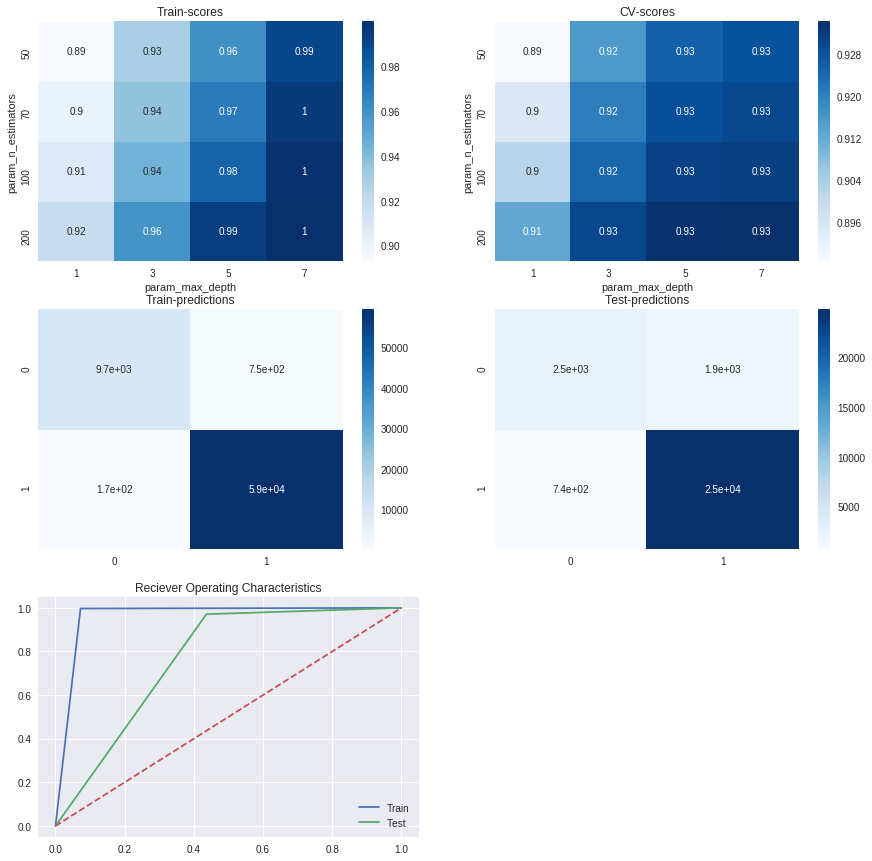

In [0]:
#Hyperparameter seach using gridsearchCV to find optimal parameters
#create array of test and train data
tfidfw2v_train = np.array(tfidfw2v_vectors_train)
tfidfw2v_test = np.array(tfidfw2v_vectors_test)

#params = {'n_estimators':[50,70,100,200],'max_depth':[1,3,5,7]}
#tfidfw2v_grid = GridSearchCV(XGBClassifier(learning_rate=0.2,gamma=0.1),params,scoring='roc_auc',cv=5,n_jobs=-1,verbose=10)#learning_rate+0.1,gamma+0.1 to avoid overfitting
#tfidfw2v_grid.fit(tfidfw2v_train,y_train)
#f = open('XGB4.pkl','wb')
#pickle.dump(tfidfw2v_grid,f)
print('The optimal parameters are',tfidfw2v_grid.best_params_)

#create pivot tables to visulize train and test scores
df = pd.DataFrame(tfidfw2v_grid.cv_results_)
pvt_train = df.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_train_score')
pvt_test = df.pivot(index='param_n_estimators',columns='param_max_depth',values='mean_test_score')

#optimal depth and estimators
optimal_depth = tfidfw2v_grid.best_estimator_.max_depth
optimal_estimators = tfidfw2v_grid.best_estimator_.n_estimators

#train a XGBClassifier using the best parameters
xgb = XGBClassifier(n_estimators=optimal_estimators,max_depth=optimal_depth)
xgb.fit(tfidfw2v_train,y_train)

#Use the best model to predict on test and train data
y_pred = xgb.predict(tfidfw2v_test)
train_pred = xgb.predict(tfidfw2v_train)

conf_train = confusion_matrix(y_train,train_pred)
conf_test = confusion_matrix(y_test,y_pred)

#obtain fpr,tpr from roc_curve
fpr,tpr,_ = roc_curve(y_train,train_pred)
fpr2,tpr2,_ = roc_curve(y_test,y_pred)

#plot heatmap and roc curves
plt.figure(1,figsize=(15,15))
plt.subplot(3,2,1)
plt.title('Train-scores')
sn.heatmap(pvt_train,cmap='Blues',annot=True)
plt.subplot(3,2,2)
plt.title('CV-scores')
sn.heatmap(pvt_test,cmap='Blues',annot=True)
plt.subplot(3,2,3)
plt.title('Train-predictions')
sn.heatmap(conf_train,cmap='Blues',annot=True)
plt.subplot(3,2,4)
plt.title('Test-predictions')
sn.heatmap(conf_test,cmap='Blues',annot=True)
plt.subplot(3,2,5)
plt.title('Reciever Operating Characteristics')
plt.plot(fpr,tpr,label='Train')
plt.plot(fpr2,tpr2,label='Test')
plt.plot([0,1],[0,1],linestyle='--')
plt.legend()
plt.show()


# [6] Conclusions

In [41]:
#prettytable to compare all the models
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ['Ensemble Algorithm','Vectorizer','max_depth','n_estimators']
x.add_row(['RandomForestClassifier','BagOfWords','100','200'])
x.add_row(['','TF-IDF','100','200'])
x.add_row(['','AverageWord2Vec','13','200'])
x.add_row(['','Tf-idf weighed Word2Vec','13','200'])
x.add_row(['','','',''])
x.add_row(['XGBoost','BagOfWords','09','200'])
x.add_row(['','TF-IDF','09','200'])
x.add_row(['','AverageWord2Vec','07','200'])
x.add_row(['','Tf-idf weighed Word2Vec','07','200'])
print(x)

+------------------------+-------------------------+-----------+--------------+
|   Ensemble Algorithm   |        Vectorizer       | max_depth | n_estimators |
+------------------------+-------------------------+-----------+--------------+
| RandomForestClassifier |        BagOfWords       |    100    |     200      |
|                        |          TF-IDF         |    100    |     200      |
|                        |     AverageWord2Vec     |     13    |     200      |
|                        | Tf-idf weighed Word2Vec |     13    |     200      |
|                        |                         |           |              |
|        XGBoost         |        BagOfWords       |     09    |     200      |
|                        |          TF-IDF         |     09    |     200      |
|                        |     AverageWord2Vec     |     07    |     200      |
|                        | Tf-idf weighed Word2Vec |     07    |     200      |
+------------------------+--------------